In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

**Get Model files and Datasets from cloud APIs**

In [2]:
!wget https://storage.googleapis.com/columbia_applied_deep_learning/demand_forecasting.zip  \
    -O ./demand_forecasting.zip

--2019-05-19 04:56:46--  https://storage.googleapis.com/columbia_applied_deep_learning/demand_forecasting.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3361698 (3.2M) [application/zip]
Saving to: ‘./demand_forecasting.zip’

./demand_forecastin 100%[===================>]   3.21M  --.-KB/s    in 0.02s   

2019-05-19 04:56:46 (148 MB/s) - ‘./demand_forecasting.zip’ saved [3361698/3361698]



In [0]:
import zipfile
local_zip = './demand_forecasting.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [4]:
!ls -al

total 7284
drwxr-xr-x 1 root root    4096 May 19 04:35 .
drwxr-xr-x 1 root root    4096 May 19 04:33 ..
drwxr-xr-x 1 root root    4096 May 16 16:08 .config
-rw-r--r-- 1 root root 3361698 May 19 03:13 demand_forecasting.zip
drwxr-xr-x 2 root root    4096 May 19 04:35 __MACOSX
-rw-r--r-- 1 root root  189008 May 19 04:56 model1_eu.hdf5
-rw-r--r-- 1 root root  188968 May 19 04:56 model1_id2.hdf5
-rw-r--r-- 1 root root  171048 May 19 04:56 model1_th.hdf5
-rw-r--r-- 1 root root  901416 May 19 04:56 model2_eu.hdf5
-rw-r--r-- 1 root root  901312 May 19 04:56 model2_id2.hdf5
-rw-r--r-- 1 root root  901312 May 19 04:56 model2_th.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:56 model3_eu.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:56 model3_id2.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:56 model3_th_exp_120.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:56 model3_th_exp.hdf5
-rw-r--r-- 1 root root  142760 May 19 04:56 model3_th.hdf5
-rw-r--r-- 1 root root    8090 May 19 04:56 Product1-Dataset

**Imports**

In [5]:
import pandas as pd
import numpy as np
import argparse
import os
import platform
import datetime, time
import datetime as dt
import warnings
from IPython.core.display import display, HTML
import tensorflow as tf
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input, LSTM, TimeDistributed,RepeatVector, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,RemoteMonitor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import load_model
import sys
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('default')
plt.style.use('seaborn-deep')
sns.set(style="whitegrid")
sns.set_context("talk")

%matplotlib inline
init_notebook_mode(connected=True)

In [0]:
checkpoint_dir = './'
model_filename = 'model3_th_exp_120.hdf5'
data_filename = 'Product1-Dataset-th-2year.csv'
train_model=False

In [7]:
tf.__version__

'2.0.0-alpha0'

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def plotly_df(df, title='', annotations=None):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines+markers')
    xaxis = dict(title='Time Steps',type='date', rangeslider=dict(visible=True))
    
    data = [go.Scatter(y=df[c], name=c,  **common_kw) for c in df.columns]
    layout = dict(title=title, showlegend=True, annotations=annotations, xaxis=xaxis, )
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [0]:
def create_timeseries_dataset(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var_lag%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var_roll%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var_roll%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
def timeseries_train_test_split(X, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    train = X[:test_index]
    test = X[test_index:]
    
    return train, test

**Read the Dataset & add index**

In [0]:
df_raw = pd.read_csv(filepath_or_buffer=data_filename, header=0, names=None, usecols=['date', 'sale_amt'], parse_dates=[0])

In [0]:
df_raw.index = df_raw.date
df_raw.drop(['date'], inplace=True, axis=1)

**Plot the dataset**

In [14]:
configure_plotly_browser_state()
plotly_df(df_raw, title='Timeseries')

**Dropping first few days as there is no defined pattern in the beginnig of business**

In [0]:
df_raw =df_raw[60:-1]

In [16]:
configure_plotly_browser_state()
plotly_df(df_raw, title='Timeseries')

**Convert the data to timeseries format; Split the data into test and training sets**

In [0]:
timesteps=120
rolling_days=14
df_to_ts = create_timeseries_dataset(df_raw, n_in=timesteps, n_out=rolling_days, dropnan=True)

In [0]:
train_dataset, test_dataset = timeseries_train_test_split(df_to_ts, 0.12)

In [19]:
print (train_dataset.shape, test_dataset.shape)

(439, 134) (60, 134)


**Scale the data using MinMaxScaler**

In [20]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_dataset)

train_scaled = scaler.transform(train_dataset)
test_scaled = scaler.transform(test_dataset)

x_train_scaled = train_scaled[:, :timesteps]
y_train_scaled = train_scaled[:, timesteps:]

x_test_scaled = test_scaled[:, :timesteps]
y_test_scaled = test_scaled[:, timesteps:]

print('test_scaled shape: '  + str(test_scaled.shape))
print('train_scaled shape: '  + str(train_scaled.shape))

test_scaled shape: (60, 134)
train_scaled shape: (439, 134)


**Model Definition**

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((timesteps, 1), input_shape=(timesteps,)))
model.add(tf.keras.layers.SimpleRNN(64, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=False))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(rolling_days))
model.compile('adam', loss='mse')


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 120, 1)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 120, 64)           4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                462       
Total params: 8,846
Trainable params: 8,846
Non-trainable params: 0
_________________________________________________________________


In [0]:
validation_data = (x_test_scaled, y_test_scaled)
c = [
      ModelCheckpoint(checkpoint_dir + model_filename, save_best_only=True,monitor='val_loss', mode='min', verbose=1, period=1),
      EarlyStopping(monitor='val_loss', min_delta=0, patience=200, verbose=1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=55, min_lr=0.000001, verbose=1)]
            

In [0]:
if train_model:
  history = model.fit(x_train_scaled, y_train_scaled, epochs=1500,verbose=1, batch_size=14, validation_data=validation_data, callbacks=c, shuffle=False)

Train on 439 samples, validate on 60 samples
Epoch 1/1500
434/439 [============================>.] - ETA: 0s - loss: 0.1195
Epoch 00001: val_loss improved from inf to 0.05151, saving model to /content/model3_th_exp_120.hdf5
439/439 [==============================] - 14s 33ms/sample - loss: 0.1187 - val_loss: 0.0515
Epoch 2/1500
434/439 [============================>.] - ETA: 0s - loss: 0.0397
Epoch 00002: val_loss improved from 0.05151 to 0.04085, saving model to /content/model3_th_exp_120.hdf5
439/439 [==============================] - 12s 28ms/sample - loss: 0.0397 - val_loss: 0.0409
Epoch 3/1500
434/439 [============================>.] - ETA: 0s - loss: 0.0345
Epoch 00003: val_loss improved from 0.04085 to 0.03421, saving model to /content/model3_th_exp_120.hdf5
439/439 [==============================] - 12s 28ms/sample - loss: 0.0345 - val_loss: 0.0342
Epoch 4/1500
434/439 [============================>.] - ETA: 0s - loss: 0.0303
Epoch 00004: val_loss improved from 0.03421 to 0.030

**Save the model for future prediction**

In [0]:
# from google.colab import files
# files.download(model_filename)

**Plot Training and Validation loss**

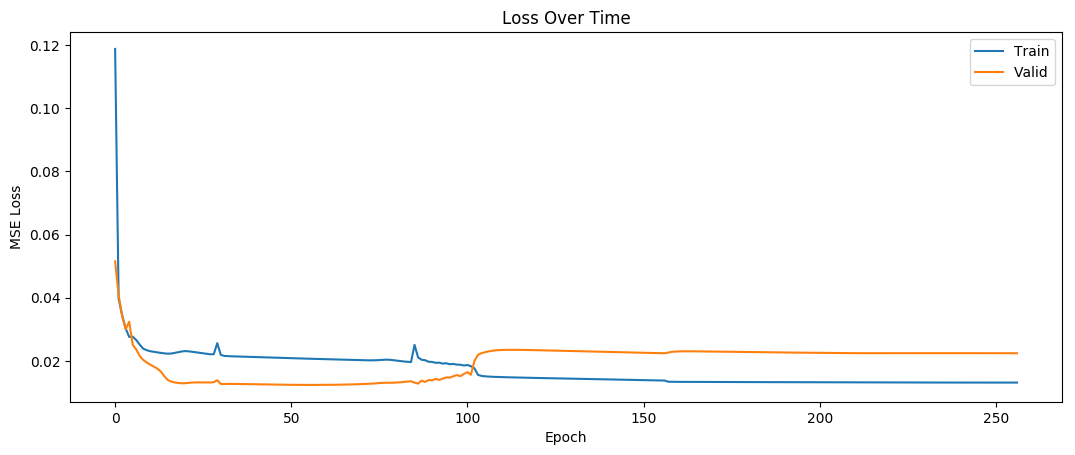

In [0]:
if train_model:  
  plt.style.use('default')
  fig, ax = plt.subplots(facecolor='w')
  fig.set_size_inches(fig.get_figwidth() * 2.0, fig.get_figheight() * 1.0)

  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])

  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title('Loss Over Time')
  plt.legend(['Train','Valid'])
  plt.show()

**Load saved model for predictions**

In [0]:
model_from_file = load_model(checkpoint_dir + model_filename)

**This function predicts on the training dataset and returns Original and Predicted values as two separate dataframes**

In [0]:
def inverse_transform_out(scaler=scaler, x_scaled=x_test_scaled, y_scaled=y_test_scaled, dataset=test_dataset, from_model=model):
  
  # This function creates dataframes for true and predicted values. It can be called for train, test and validation datasets. 
  # Uses the model, scaler and scaled datasets as inputs
  # output is two dataframes; one for true rolling days values and the other for predictions
  
  yhat = from_model.predict(x_scaled)
  
  pred_cols = ['pred_'+str(i) for i in range(1, rolling_days+1)]
  scaler_input = np.concatenate([x_scaled, yhat], axis=1)
  scaler_output = scaler.inverse_transform(scaler_input)
  df_pred = pd.DataFrame(scaler_output[:, timesteps:],columns=pred_cols)
  df_pred.index = dataset.index
  
  true_cols = ['true_'+str(i) for i in range(1,rolling_days+1)] 
  scaler_input = np.concatenate([x_scaled, y_scaled], axis=1)
  scaler_output = scaler.inverse_transform(scaler_input)
  df_true = pd.DataFrame(scaler_output[:, timesteps:],columns=true_cols)    
  df_true.index = dataset.index
  
  return df_true, df_pred

**Prediction for a given date**

In [0]:
def prediction(start_dt, df_true, df_pred):
  
  end_date= start_dt + datetime.timedelta(rolling_days - 1 )
  idx = pd.date_range(start=start_dt, end=end_date)
  dt_pred = df_pred.loc[start_dt]
  dt_pred.index = idx
  dt_true = df_true.loc[start_dt]
  dt_true.index = idx
  results = pd.concat([dt_true,dt_pred], axis=1)
  results.columns=['Original','Predicted']
  
  return results

**MAPE Function**

In [0]:
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_pred - y_true)) / (y_pred+ 1e-7)) * 100

**Inference plots and Evaluation Metrics**

In [0]:
df_true, df_pred = inverse_transform_out(from_model=model_from_file)

In [0]:
results = prediction(datetime.datetime(2019,3,4), df_true, df_pred)

In [30]:
configure_plotly_browser_state()
plotly_df(results, title="Predictions")

In [31]:
configure_plotly_browser_state()
plotly_df(df_raw, title="Dataset")

In [32]:
rmse = math.sqrt(mean_squared_error(results['Original'].values, results['Predicted'].values))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 326614.305


In [33]:
mape = mean_absolute_percentage_error(np.array(results['Predicted'].values),np.array(results['Original'].values))
print ('Test MAPE: %.3f' %mape)

Test MAPE: 22.998


In [34]:
err = (abs(sum(results['Predicted'].values) - sum(results['Original'].values)) / (sum(results['Original'].values))) *100
print ('Prediction Error: %.2f%%' %err)

Prediction Error: 2.55%
